In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.metrics import mean_absolute_percentage_error

### Input data

In [ ]:
data = pd.DataFrame({'data':[   0.25, 1.21, 4.49, 6.57, 9.73, 12.33, 13.65, 12.87, 11.64, 9.38, 7.27, 6.11,
                                6.04, 7.38, 9.67, 12.35, 15.52, 18.21, 18.92, 18.76, 17.46, 15.71, 13.89, 11.97,
                                12.07, 13.19, 15.40, 18.46, 21.69, 24.19, 24.73, 24.51, 23.32, 21.55, 19.61, 18.10,
                                18.29, 19.30, 21.84, 24.60, 27.58, 29.60, 31.02, 30.61, 29.72, 27.63, 25.38, 24.04
                    ]})

" data = pd.DataFrame({'data':[   0.0, 1.16, 3.5, 6.5, 9.5, 11.83, 13.0, 12.83, 11.5, 9.5, 7.5,  6.16,\n                                6.0, 7.16, 9.5, 12.5, 15.5, 17.83, 19.0, 18.83, 17.5, 15.5, 13.5, 12.16, \n                                12.0, 13.16, 15.5, 18.5, 21.5, 23.83, 25.0, 24.83, 23.5, 21.5, 19.5, 18.16, \n                                18.0, 19.16, 21.5, 24.5, 27.5, 29.83, 31.0, 30.83, 29.5, 27.5, 25.5, 24.16\n                    ]}) "

In [616]:
len(data)

48

In [617]:
data['t'] = np.arange(len(data))

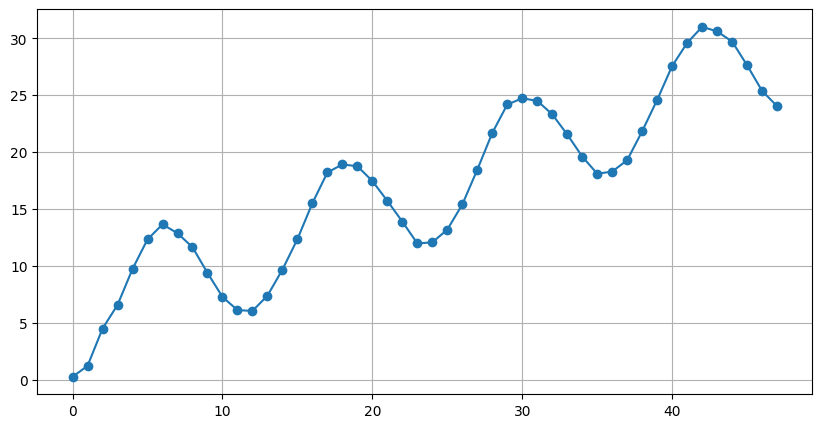

In [618]:
data['data'].plot(figsize=(10,5), marker='o')
plt.grid(True)
plt.show()

### Train data

In [619]:
train = data[:24].copy()

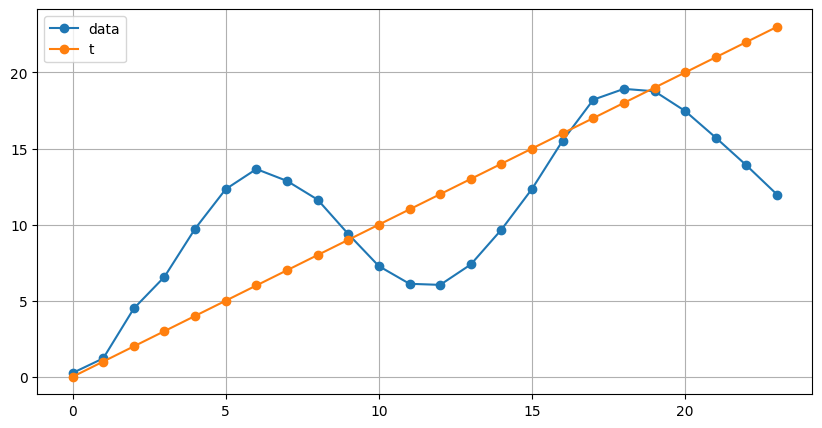

In [620]:
train.plot(figsize=(10,5), marker='o')
plt.grid(True)
plt.show()

### Get Trend by OLS

In [621]:
# Add a constant (intercept) to the model
X = sm.add_constant(train['t'])  # Adds a constant term to the predictor (intercept)
y = train['data']

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   data   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     23.90
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           6.90e-05
Time:                        11:51:47   Log-Likelihood:                -64.588
No. Observations:                  24   AIC:                             133.2
Df Residuals:                      22   BIC:                             135.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7110      1.475      3.193      0.0

In [622]:
slope = results.params[1]  # m (slope)
intercept = results.params[0]  # c (intercept)

print(f"Trend equation: y(t) = {slope:.2f} * t + {intercept:.2f}")

Trend equation: y(t) = 0.54 * t + 4.71


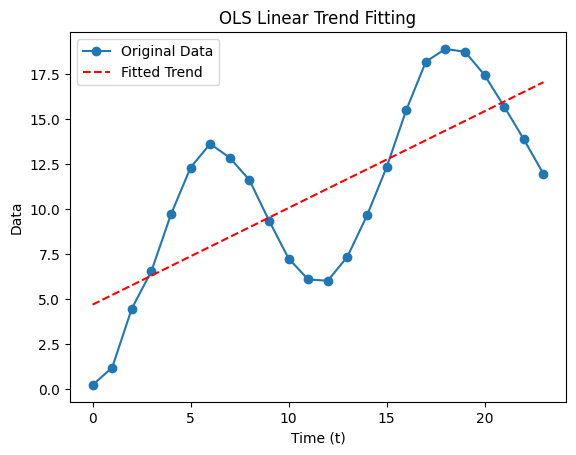

In [623]:
# Plot the original data
plt.plot(train['t'], train['data'], label='Original Data', marker='o')

# Plot the fitted trend line
plt.plot(train['t'], results.fittedvalues, label='Fitted Trend', color='red', linestyle='--')

# Labels and title
plt.xlabel('Time (t)')
plt.ylabel('Data')
plt.legend()
plt.title('OLS Linear Trend Fitting')

# Show plot
plt.show()

### Removing the trend = residuals = seasonality

In [624]:
# Extract the residuals (the part of data not explained by the trend)
train['residuals'] = train['data'] - results.fittedvalues
train.head(5)


,data,t,residuals
0,0.25,0,-4.461033
1,1.21,1,-4.038407
2,4.49,2,-1.295781
3,6.57,3,0.246845
4,9.73,4,2.869471


### Get seasonality params

In [625]:
from scipy.optimize import curve_fit

# Define the sine function to fit the seasonal component
def seasonal_model(t, A, phi):
    return A * np.sin(2 * np.pi * t / 12 + phi)  # Assuming period P=12 months

# Fit the seasonal model to the residuals
params, covariance = curve_fit(seasonal_model, train['t'], train['residuals'], p0=[5, 0])  # p0 is initial guess for A and phi

# Extract the amplitude and phase shift
A = params[0]
phi = params[1]

print(f"Amplitude (A): {A:.2f}")
print(f"Phase Shift (phi): {phi:.2f}")


Amplitude (A): 5.01
Phase Shift (phi): -1.52


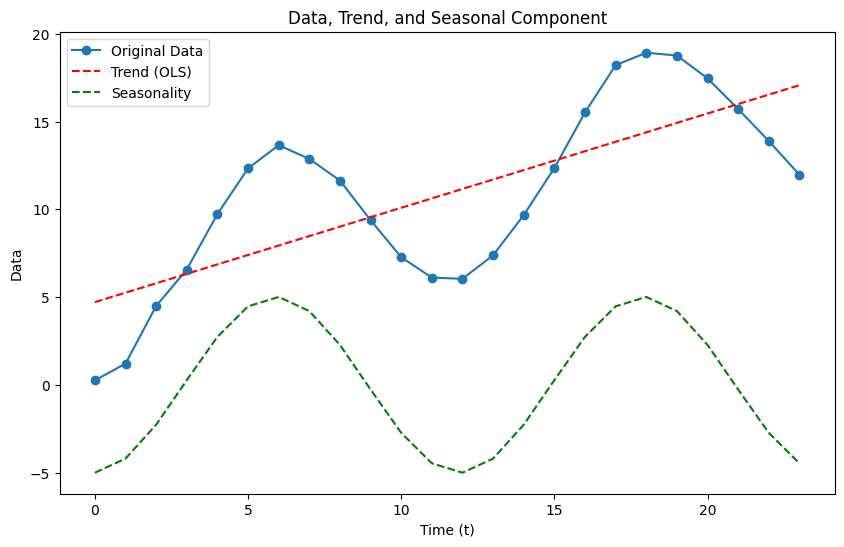

In [626]:
# Calculate the seasonal values using the fitted parameters
train['seasonality'] = seasonal_model(train['t'], *params)

# Plot the original data, trend line, and seasonality
plt.figure(figsize=(10, 6))
plt.plot(train['t'], train['data'], label='Original Data', marker='o')
plt.plot(train['t'], results.fittedvalues, label='Trend (OLS)', color='red', linestyle='--')
plt.plot(train['t'], train['seasonality'], label='Seasonality', color='green', linestyle='--')
plt.xlabel('Time (t)')
plt.ylabel('Data')
plt.legend()
plt.title('Data, Trend, and Seasonal Component')
plt.show()


### Compose the equation and predict

In [627]:
# Predict the next 24 months
future_months = np.arange(len(train), len(train) + 24)  # Time steps for the next 24 months

# Predict the trend for future months: T(t) = m * t + c
predicted_trend = slope * future_months + intercept

# Predict the seasonality for future months: S(t) = A * sin(2 * pi * t / 12 + phi)
predicted_seasonality = A * np.sin(2 * np.pi * future_months / 12 + phi)

# Combine trend and seasonality to get the predicted values
predicted_values = predicted_trend + predicted_seasonality

# Create a DataFrame with the future months and predicted values
future_data = pd.DataFrame({'t': future_months, 'predicted_values': predicted_values})

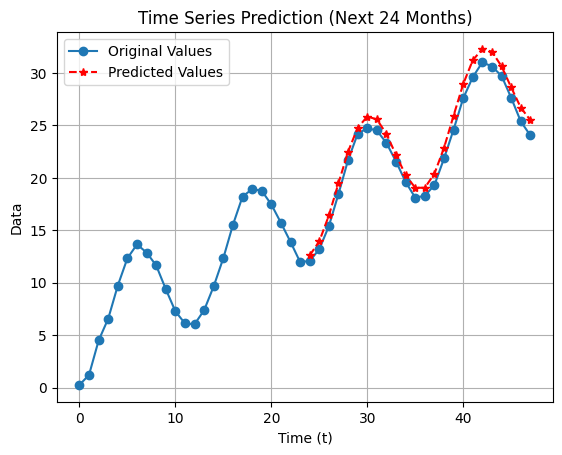

In [628]:
# Plot the predictions along with the original data

plt.plot(data['t'], data['data'], marker='o', label='Original Values')

plt.plot(future_data['t'], future_data['predicted_values'], label='Predicted Values', color='red', linestyle='--', marker='*')
plt.xlabel('Time (t)')
plt.ylabel('Data')
plt.grid(True)
plt.legend()
plt.title('Time Series Prediction (Next 24 Months)')
plt.show()


### Metric

In [629]:
real = np.array(data['data']).copy()
real = real[-24:]
real

array([12.07, 13.19, 15.4 , 18.46, 21.69, 24.19, 24.73, 24.51, 23.32,
       21.55, 19.61, 18.1 , 18.29, 19.3 , 21.84, 24.6 , 27.58, 29.6 ,
       31.02, 30.61, 29.72, 27.63, 25.38, 24.04])

In [631]:
predicted = np.array(future_data['predicted_values'])
predicted

array([12.60047267, 13.94246673, 16.41062832, 19.48760443, 22.49291072,
       24.76526668, 25.8397853 , 25.57253907, 24.17912531, 22.17689702,
       20.24633856, 19.04873042, 19.04895963, 20.39095369, 22.85911527,
       25.93609139, 28.94139767, 31.21375364, 32.28827225, 32.02102602,
       30.62761226, 28.62538397, 26.69482552, 25.49721737])

In [634]:
mape = round(mean_absolute_percentage_error(real, predicted)*100,2)
mape

4.55